# Сравнение сырых данных GA и DMPkit.TM
Выполняется в рамках задачи CLDSUP-1218.
## Суть
На qa- и dev-сайтах S7 размещён тестовый контейнер DMPkit.TM, с помощью которого настроена пересылка событий GTM в DMPkit методом, описанным Катей Малеевой в письме "GA vs DMP данные". По факту наблюдается существенная разница между количеством событий в выгрузках из обеих систем. Нужно разобраться, чем вызвана разница.
## Метод
В качестве одного из атрибутов события добавлен текущий таймстемп + случайная строка, вычисляющийся перед пушем события на стороне фронт-энда. Этот атрибут можно использовать как своего рода уникальный идентификатор трекаемого события как в GA, так и в DMPkit.TM. В данном исследовании выгруженные из обеих систем за определённый промежуток времени события джойнятся по этому атрибуту, и далее изучаются:
1. Почему некоторые события не удалось сджойнить (есть в одной системе, но нет в другой),
2. Есть ли разница в каких-то атрибутах у тех событий разных систем, которые удалось сджойнить.

## Читаем и подготавливаем данные выгрузок к объединению

### Пути к csv-выгрузкам из соответствующих систем (единственная внешняя зависимость отчёта)
Как получить выгрузки:
* Из GA: см. письмо Кати Малеевой "GA vs DMP данные". Выгрузить из  google spreadsheats как csv, вручную отрезать первые строки, которые не относятся к табличному формату, до заголовков.
* Из DMPkit: выполнить приложенный скрипт "gtm_events_export.py" в pyspark на ноде кластера DMPkit.

In [486]:
path_to_ga_export = 'C://Users/dlist/Downloads/ga_events_export_concated.csv'
path_to_dmpkit_export = 'C://Users/dlist/Downloads/gtm_events_export2.csv'

### Импорты и настройки самой тетрадки. Чисто техническая секция.

In [487]:
# imports and some shit to make anaconda behave
from __future__ import division, print_function

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 20)
import pylab as plt
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

from datetime import datetime

### Читаем и приводим к удобному виду выгрузку из GTM

In [488]:
# read and prepare GA dataframe
ga = pd.read_csv(path_to_ga_export, sep=',', quotechar='"', encoding='utf-8')
ga.rename(columns={'ga:dimension8': 'ga_timestamp', 
                   'ga:dimension10': 'random_ga_event_param',
                   'ga:dimension11': 'ts_from_js',
                  'ga:dimension12': 'gtm_push_ts',
                  'ga:datehourminute': 'datehourminute',
                  'Event Category': 'event_category',
                  'Event Action': 'event_action',
                  'Event Label': 'event_label',
                  'Page': 'page',
                  'Total Events': 'ga_group_total_events'}, inplace=True)

ga['page'] = ga['page'].apply(lambda x: x.split('?')[0])
ga['page'] = ga['page'].apply(lambda x: x if x[-1] != '/' else x[:-1])

Проверяем, что группировка по `random_ga_event_param` даёт уникальные события и таким образом мы можем считать его уникальным идентификатором события. Сама группировка преднастроена в выгрузке, а `ga_group_total_events` -- количество событий в группе. Видим, что это не полностью верно, но отклонением можно пренебречь.

In [489]:
ga.groupby(['ga_group_total_events']).size().sort_values(ascending = False)

ga_group_total_events
1    150712
2        65
dtype: int64

Рисуем заполненность атрибутов событий из GA, чтобы получить общее представление о выгрузке

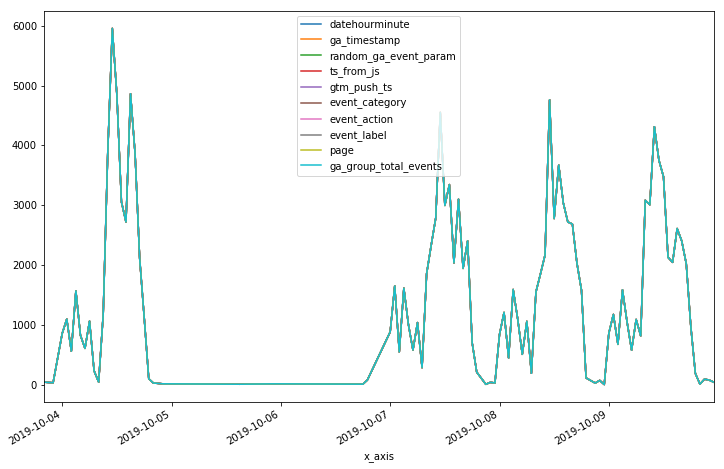

In [490]:
# ga check
ga_check = ga
ga_check['x_axis'] = ga['datehourminute'].apply(lambda x: datetime(year = int(str(x)[:4]),
                                                                     month = int(str(x)[4:6]),
                                                                     day = int(str(x)[6:8]),
                                                                     hour = int(str(x)[8:10])))

ga_check.groupby('x_axis').count().plot()

### Читаем и приводим к удобному виду выгрузку из DMPkit.TM

In [491]:
# read and prepare DMPkit dataframe
dmpkit = pd.read_csv(path_to_dmpkit_export, sep=';', quotechar='"', encoding='utf-8')

# В ранних версиях тегов ts_from_js собирался в неправильном формате, здесь мы чистим этот момент.
def convert_to_int(val):
    try:
        return int(val)
    except:
        return np.nan


dmpkit['ts_from_js'] = dmpkit['ts_from_js'].apply(convert_to_int)

Рисуем заполненность атрибутов событий из DMPkit, чтобы получить общее представление о выгрузке

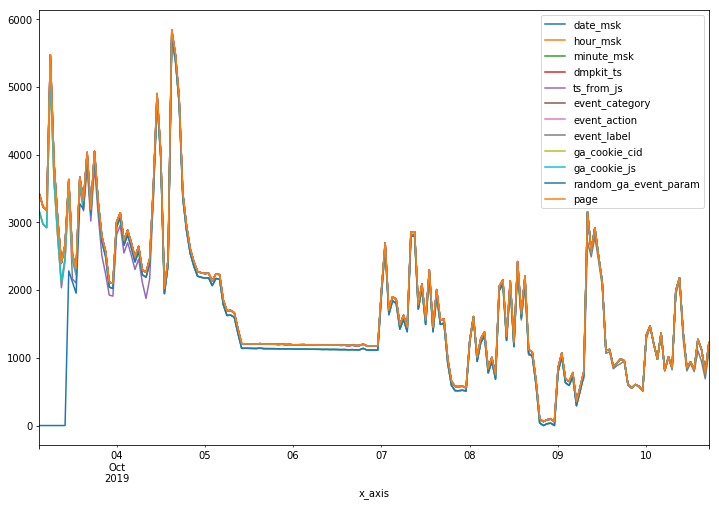

In [493]:
# dmpkit check
dmpkit_check = dmpkit
dmpkit_check['x_axis'] = dmpkit_check['dmpkit_ts'].apply(lambda x: datetime.fromtimestamp(x/1000).replace(minute=0, 
                                                                                                          second=0, 
                                                                                                          microsecond=0))

dmpkit_check.groupby('x_axis').count().plot()

## Работа с объединёнными событиями

### Объединяем события из разных выгрузок
Может выполняться около минуты, зависит от производительности локальной машины

In [494]:
joined_df = ga.set_index('random_ga_event_param').join(dmpkit.set_index('random_ga_event_param'), 
                                                       how='outer', 
                                                       lsuffix='_ga', 
                                                       rsuffix='_dmpkit')

Вычисляем вспомогательные атрибуты. Тоже выполняется долго, может быть дольше джойна.

In [495]:
# coalesce for basic event info
joined_df['event_category'] = joined_df["event_category_ga"].fillna(joined_df["event_category_dmpkit"])
joined_df['event_label'] = joined_df["event_label_ga"].fillna(joined_df["event_label_dmpkit"])
joined_df['event_action'] = joined_df["event_action_ga"].fillna(joined_df["event_action_dmpkit"])

# joined timeline for new df
joined_df['approx_ts'] = joined_df["dmpkit_ts"].fillna(joined_df["ts_from_js_ga"])
joined_df['datetime'] = joined_df['approx_ts'].apply(lambda x: datetime.fromtimestamp(x/1000).replace(minute=0, 
                                                                                                      second=0, 
                                                                                                      microsecond=0))

def intersection(row):
    if not pd.isnull(row.ts_from_js_ga) and not pd.isnull(row.dmpkit_ts):
        return 'both'
    elif not pd.isnull(row.ts_from_js_ga):
        return 'only_ga'
    else:
        return 'only_dmpkit'

joined_df['intersection'] = joined_df.apply(lambda row: intersection(row), axis=1)

def domain_kind(page):
    if pd.isnull(page):
        return np.nan
    elif 'dev-' in page:
        return 'dev-'
    elif 'qa-' in page:
        return 'qa-'
    elif 'localhost' in page:
        return 'localhost'
    else:
        return 'other'

joined_df['domain_kind'] = joined_df['page_ga'].apply(domain_kind)

### Рисуем базовую визуализацию для исследуемой проблемы
На графике -- количество событий в час, разбитое на три стека -- "события есть в обеих системах", "события есть только в GA", "события есть только в DMPkit". Идеально было бы, если бы все события были в обеих системах, однако мы видим, что значительная часть событий представлена тольоко в одной из двух систем. Далее мы будем изучать причины.

In [496]:
# filters
## take only needed attributes
df = joined_df[['datetime', 'intersection']]
## take particular timerange (where data collection had aleady been collecting right)
df = df[(df['datetime'] >= datetime(2019, 10, 7)) & 
        (df['datetime'] < datetime(2019, 10, 9, 23))]

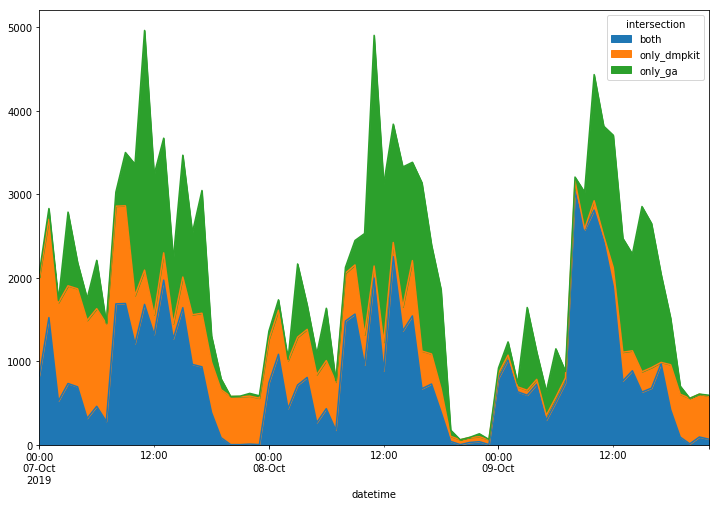

In [497]:
df.groupby(['datetime', 'intersection']).size().unstack().plot.area()

### Исследуем события, которые есть только в DMPkit

In [498]:
# filters
## take only dmpkit events
df = joined_df[joined_df['intersection'] == 'only_dmpkit']
## take only needed attributes
df = df[['datetime', 'event_category']]
## take particular timerange (where data collection had aleady been collecting right)
df = df[(df['datetime'] >= datetime(2019, 10, 7)) & 
        (df['datetime'] < datetime(2019, 10, 9, 23))]

Смотрим, сколько событий с какими `event_category` терялось в GA за выбранный промежуток времени.

In [499]:
categories_df = df.groupby(['event_category']).size().sort_values(ascending=False).reset_index().rename(columns={0: "count"})
categories_df

,event_category,count
0,CD TM3:PORTAL Banners,24291
1,CD TM:PORTAL Banners,3299
2,CD TM3:IBE2.0,900
3,CD TM3:IBE FLOW,704
4,CD TM3:IBE CS_Insurance,603
5,CD TM3:IBE GAPCS_Vehicle FLOW,482
6,CD TM3:IBE GAPCS_Hotel FLOW,277
7,CD TM3:IBE RichContent,252
8,CD TM3:Price Watch,219
9,CD TM3:IBE Select,215


Отсекаем те категории, которые внесли в расхождение совсем незначительный вклад, визуализируем остальные.

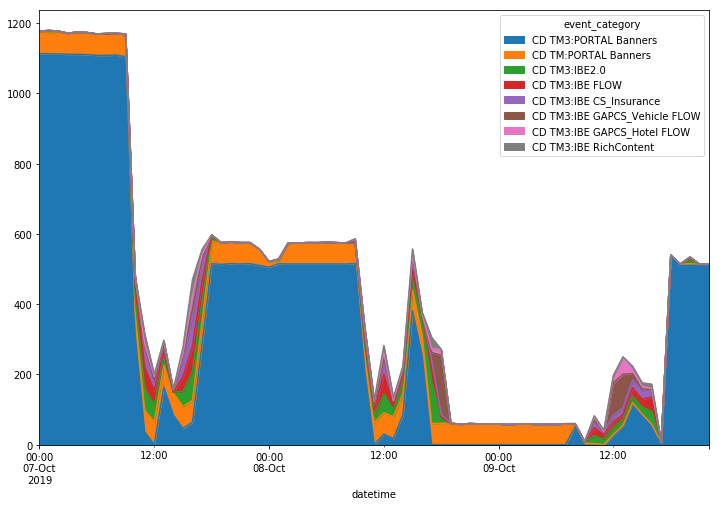

In [500]:
slice_count = 250
column_order = categories_df[categories_df['count'] > slice_count]['event_category'].values

df.groupby(['datetime', 'event_category']).size().unstack()[column_order].plot.area()

Очевидно, что подовляющее большиентво "only_dmpkit"-событий -- это события категории PORTAL Banners. Дальнейшее изучение этих событий на сайте показало, что эти события отправляются с главной страницы S7 при каждом повортоте баннера-рулетки, это примерно одно событие в 10 секунд. То, что мы наблюдаем -- это, вероятно, эффект сэмплирования: GA в своём отчёте игнорирует повторяющиеся события с одинаковыми параметра от одних и тех же пользователей.
Таким образом, для этих событий картина в DMPkit более правдоподобна, чем в GA.

### Исследуем события, которые видны только в GA

#### Базовый анализ
Для начала повторим исследование по event_category и аналогично ему сделаем исследование по конкретным страницам, на которых в DMPkit "пропадают" события. Из них будет видно, что как по категориям, так и по страницам эти события распределены гораздо более равномерно, и какие-то однозначиные выводы сделать не получается.
##### Анализ event_category по всем only_ga событиям

In [501]:
# filters
## take only ga events
df = joined_df[joined_df['intersection'] == 'only_ga']
## take only needed attributes
df = df[['datetime', 'event_category']]
## take particular timerange (where data collection had aleady been collecting right)
df = df[(df['datetime'] >= datetime(2019, 10, 7)) & 
        (df['datetime'] < datetime(2019, 10, 9, 23))]

In [502]:
categories_df = df.groupby(['event_category']).size().sort_values(ascending=False).reset_index().rename(columns={0: "count"})
categories_df

,event_category,count
0,CD TM3:IBE2.0,5709
1,CD TM3:IBE FLOW,4746
2,CD TM3:IBE CS_Insurance,3472
3,CD TM3:MYB FLOW,2777
4,CD TM3:IBE SearchForm,2254
5,CD TM3:MYB_Main Form_search,2101
6,CD TM3:IBE RichContent,1927
7,CD TM3:MYB_Main Actions_Button,1701
8,CD TM3:Price Watch,1532
9,CD TM3:MYB Reissue,1516


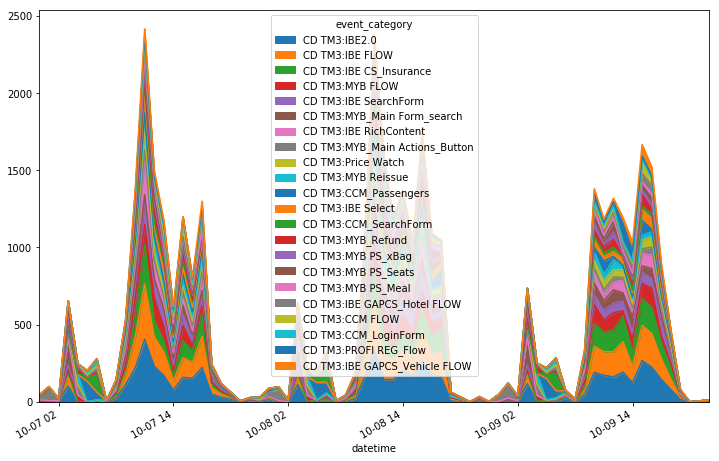

In [503]:
slice_count = 600
column_order = categories_df[categories_df['count'] > slice_count]['event_category'].values

df.groupby(['datetime', 'event_category']).size().unstack()[column_order].plot.area()

##### Анализ page по всем only_ga событиям

In [504]:
# filters
## take only ga events
df = joined_df[joined_df['intersection'] == 'only_ga']
## take only needed attributes
df = df[['datetime', 'page_ga']]
## take particular timerange (where data collection had aleady been collecting right)
df = df[(df['datetime'] >= datetime(2019, 10, 7)) & 
        (df['datetime'] < datetime(2019, 10, 9, 23))]

In [505]:
pages_df = df.groupby(['page_ga']).size().sort_values(ascending=False).reset_index().rename(columns={0: "count"})
pages_df

,page_ga,count
0,qa-myb.s7.ru/manage-order,7053
1,dev-ibe3.s7.ru/selectExactDateSearchFlights.ac...,5344
2,localhost/manage-order,4933
3,localhost/selectExactDateSearchFlights.action,3940
4,localhost/reviewFlights.action,2537
5,qa-ibe.s7.ru/manage-order,2437
6,dev-ibe3.s7.ru/reviewFlights.action,2321
7,dev-ibe3.s7.ru/searchFlights.action,2286
8,dev-myb.s7.ru/manage-order,1978
9,dev-ibe3.s7.ru/manage-order,1892


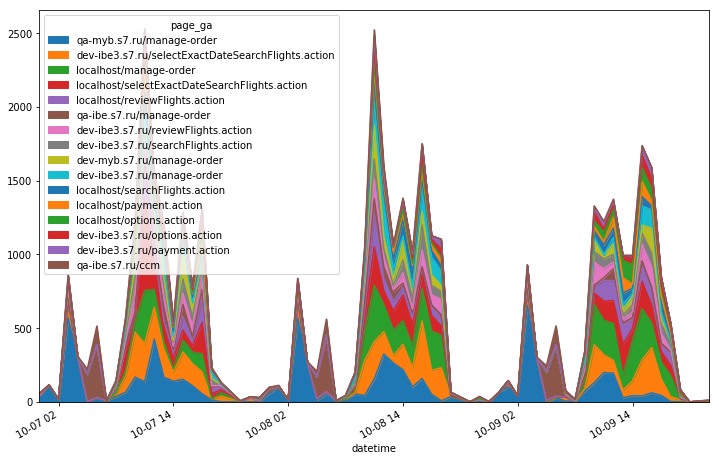

In [506]:
slice_count = 600
column_order = pages_df[pages_df['count'] > slice_count]['page_ga'].values

df.groupby(['datetime', 'page_ga']).size().unstack()[column_order].plot.area()

### Проверка гипотезы: Не  для всех событий GTM созданы условия, чтобы они дублировались в DMPkit
#### Вариант 1: не на всех страницах настроен DMPkit.TM
Если это так, то есть страницы, с которых есть события в GA, но нет ни одного события в DMPkit.TM

Выбираем множество урлов (без параметров), с которых есть события только в GA, и вычетаем из этого множества те урлы, с которых есть события не только с GA. Урлы, в которых на конце ".action", игнорируем: из-за особенностей движка сайта GA видит часть страниц как отдельные страницы с суфиксом ".action", а в урле в браузере они отображаются как одна страница "/air", соответственно так они и попадают в DMPkit.

In [507]:
df = joined_df[(joined_df['datetime'] >= datetime(2019, 10, 7)) & 
               (joined_df['datetime'] < datetime(2019, 10, 9, 23))]

pages_ga = list(df[df['intersection'] == 'only_ga']['page_ga'].drop_duplicates())
u_pages_ga = set([page.split('/')[0] for page in pages_ga])

pages_rest = list(df[df['intersection'] != 'only_ga']['page_dmpkit'].drop_duplicates())
u_pages_rest = set([page.split('/')[0] for page in pages_ga])

untracked_pages = [page for page in pages_ga if page not in pages_rest and '.action' not in page]
sorted(untracked_pages)

['192.168.0.147/manage-order',
 'dev-b2b.s7.ru/profile/registration',
 'dev-b2b.s7.ru/profile/v2',
 'dev-ibe3.s7.ru/air',
 'dev-ibe3.s7.ru/cars',
 'dev-ibe3.s7.ru/ccm',
 'dev-ibe3.s7.ru/find-order',
 'dev-ibe3.s7.ru/login',
 'dev-ibe3.s7.ru/manage-order',
 'dev-ibe3.s7.ru/pet-search',
 'dev-myb.s7.ru/ccm',
 'dev-myb.s7.ru/find-order',
 'dev-myb.s7.ru/login',
 'dev-myb.s7.ru/manage-order',
 'dev-pl-ibe-1.web.s7.ru/ccm',
 'dev-pl-ibe-1.web.s7.ru/login',
 'dev-pl-ibe-1.web.s7.ru/manage-order',
 'localhost/b2b',
 'localhost/b2bnews/novyy-reys-kogalym-novosibirsk',
 'localhost/cars',
 'localhost/ccm',
 'localhost/find-order',
 'localhost/login',
 'localhost/manage-order',
 'localhost/profile/registration',
 'localhost/profile/v2',
 'qa-b2b.s7.ru/profile/registration',
 'qa-b2b.s7.ru/profile/v2',
 'qa-ibe.s7.ru/ccm',
 'qa-ibe.s7.ru/find-order',
 'qa-ibe.s7.ru/login',
 'qa-ibe.s7.ru/manage-order',
 'qa-ibe3.s7.ru/ccm',
 'qa-ibe3.s7.ru/find-order',
 'qa-ibe3.s7.ru/login',
 'qa-ibe3.s7.ru/manag

#### Вариант 2: не для всех событий в GTM организована пересылка в DMPkit
Проверяем вычитанием множеств аналогично со страницами.

In [508]:
df = joined_df[(joined_df['datetime'] >= datetime(2019, 10, 7)) & 
               (joined_df['datetime'] < datetime(2019, 10, 9, 23))]

categories_ga = list(df[df['intersection'] == 'only_ga']['event_category'].drop_duplicates())

categories_rest = list(df[df['intersection'] != 'only_ga']['event_category'].drop_duplicates())

untracked_categories = [cat for cat in categories_ga if cat not in categories_rest]
untracked_categories

['CD TM3:MYB_Main Actions_Button',
 'CD TM3:MYB FFP_suggest',
 'CD TM3:MYB_onHold Form_checkout',
 'CD TM3:MYB_Refund',
 'CD TM3:MYB FLOW',
 'CD TM3:MYB PS_xBag',
 'CD TM3:MYB PS_Meal',
 'CD TM3:MYB PS_Seats',
 'CD TM3:MYB PS_Seats Errors',
 'CD TM3:CCM_LoginForm',
 'CD TM3:CCM_SearchForm',
 'CD TM3:CCM_FormCancelOrder',
 'CD TM3:MYB_Passengers',
 'CD TM3:MYB_Main Form_search',
 'CD TM3:MYB PS_Meal Meal',
 'CD TM3:MYB PS_Meal Errors',
 'CD TM3:CCM PS_Seats',
 'CD TM3:CCM_Main Actions_Button',
 'CD TM3:MYB Reissue',
 'CD TM3:MYB PS_xBag Errors',
 'CD TM3:CCM FFP_suggest',
 'CD TM3:CCM FLOW',
 'CD TM3:MYB_PopupContactCC',
 'CD TM3:MYB_BlockedAir',
 'CD TM3:MYB Reissue_Errors',
 'CD TM3:CCM_Refund',
 'CD TM3:CCM_onHold Form_checkout',
 'CD TM3:CCM_Passengers',
 'CD TM3:CCM PS_xBag Errors',
 'CD TM3:CCM PS_Meal Errors',
 'CD TM3:CCM PS_Seats Errors',
 'CD TM3:CCM PS_xBag',
 'CD TM3:CCM PS_Meal',
 'CD TM3:CCM_FormManualRefund',
 'CD TM3:CCM_FormAddPet',
 'CD TM3:CCM_PaymentDetails',
 'CD TM

#### Оценка вклада "ненастроенности"
Видно, что и для страниц, и для событий у нас получились непустые множества. Посчитаем, какой процент случаев непопадания событий в DMPkit это объясняет.

In [509]:
all_missed = df[df['intersection'] == 'only_ga']

def classify_miss(row):
    if row['page_ga'] in untracked_pages and row['event_category'] in untracked_categories:
        return 'both_page_and_category_untracked'
    elif row['page_ga'] in untracked_pages:
        return 'page_untracked'
    elif row['event_category'] in untracked_categories:
        return 'category_untracked'
    else:
        return 'still_unknown_reason'

all_missed['miss_reason'] = all_missed.apply(classify_miss, axis=1)

all_missed.groupby(['miss_reason']).size()

miss_reason
both_page_and_category_untracked    21926
category_untracked                   1743
page_untracked                        216
still_unknown_reason                24680
dtype: int64

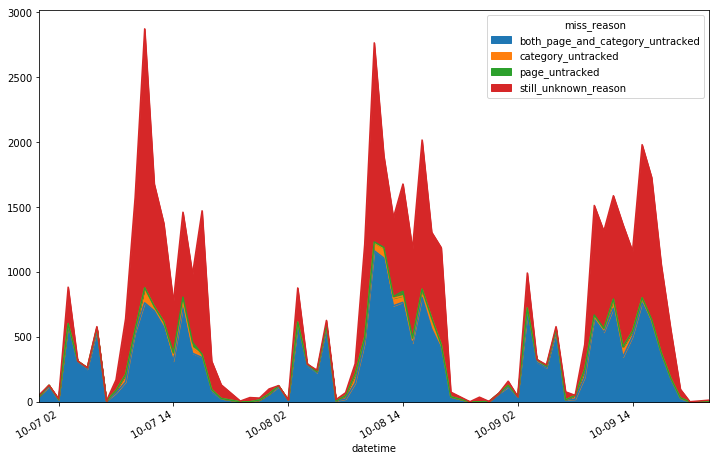

In [510]:
all_missed.groupby(['datetime', 'miss_reason']).size().unstack().plot.area()

Можно сделать такой вывод:
Половина непопавших в DMPkit событий не попадает туда из-за того, что на соответствующей странице не установлен сниппет DMPkit.TM, либо что-то препятствует работе этого скрипта на этой странице.

### Исследование частично непопадающих в DMPkit событий
#### Промежуточная визуализация разбиения по event_category и page
Посмотрим, на какие события и на каких страницах теряются не полностью, как при отсутствии сниппета, а частично.

In [511]:
# filters
## take only missed for unknown reason
df = all_missed[all_missed['miss_reason'] == 'still_unknown_reason']
## take particular timerange (where data collection had aleady been collecting right)
df = df[(df['datetime'] >= datetime(2019, 10, 7)) & 
        (df['datetime'] < datetime(2019, 10, 9, 23))]

In [512]:
categories_df = df.groupby(['event_category']).size().sort_values(ascending=False).reset_index().rename(columns={0: "count"})
categories_df

,event_category,count
0,CD TM3:IBE2.0,5706
1,CD TM3:IBE FLOW,4746
2,CD TM3:IBE CS_Insurance,3471
3,CD TM3:IBE SearchForm,2254
4,CD TM3:IBE RichContent,1927
5,CD TM3:Price Watch,1532
6,CD TM3:IBE Select,1446
7,CD TM3:IBE GAPCS_Hotel FLOW,984
8,CD TM3:IBE GAPCS_Vehicle FLOW,662
9,CD TM3:IBE GAPCS_AEX FLOW,446


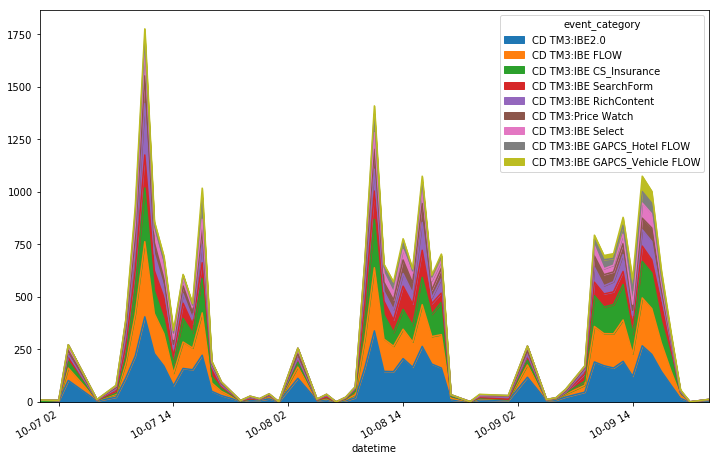

In [513]:
slice_count = 600
column_order = categories_df[categories_df['count'] > slice_count]['event_category'].values

df.groupby(['datetime', 'event_category']).size().unstack()[column_order].plot.area()

In [514]:
# filters
## take only missed for unknown reason
df = all_missed[all_missed['miss_reason'] == 'still_unknown_reason']
## take only needed attributes
df = df[['datetime', 'page_ga']]

In [515]:
pages_df = df.groupby(['page_ga']).size().sort_values(ascending=False).reset_index().rename(columns={0: "count"})
pages_df

,page_ga,count
0,dev-ibe3.s7.ru/selectExactDateSearchFlights.ac...,5341
1,localhost/selectExactDateSearchFlights.action,3940
2,localhost/reviewFlights.action,2537
3,dev-ibe3.s7.ru/reviewFlights.action,2321
4,dev-ibe3.s7.ru/searchFlights.action,2283
5,localhost/searchFlights.action,1740
6,localhost/options.action,1282
7,dev-ibe3.s7.ru/options.action,1160
8,localhost/payment.action,1157
9,dev-ibe3.s7.ru/payment.action,1057


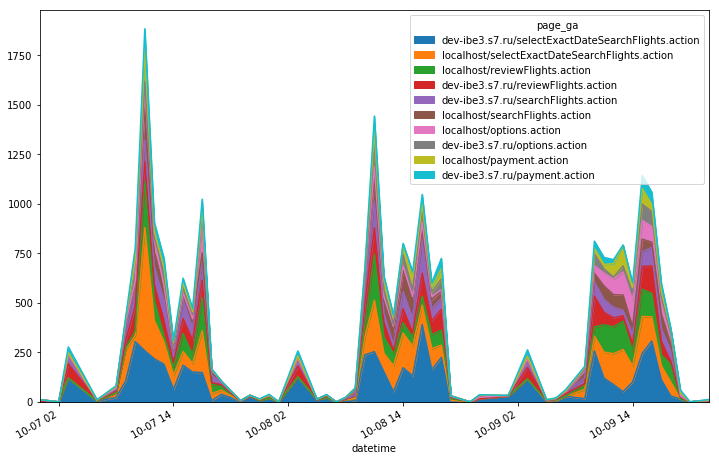

In [516]:
slice_count = 600
column_order = pages_df[pages_df['count'] > slice_count]['page_ga'].values

df.groupby(['datetime', 'page_ga']).size().unstack()[column_order].plot.area()

Отсюда видно, что преобладают события с dev-ibe3.s7.ru и локального запуска его же страниц
### Гипотеза: события пропадают на dev и не пропадают на uat
Для проверки сгруппируем все домены по вхождению dev, uat или localhost и посмотрим распределение причин пропадания из-за некорректного трекинга, рассмотренные выше.

In [517]:
# filters
## take only ga and both events
df = joined_df[joined_df['intersection'] != 'only_dmpkit']
## take particular timerange (where data collection had aleady been collecting right)
df = df[(df['datetime'] >= datetime(2019, 10, 7)) & 
        (df['datetime'] < datetime(2019, 10, 9, 23))]

Добавим "no_miss" для случая, когда события видны в обеих системах

In [518]:
def classify_miss2(row):
    if row['intersection'] != 'only_ga':
        return 'no_miss'
    elif row['page_ga'] in untracked_pages and row['event_category'] in untracked_categories:
        return 'both_page_and_category_untracked'
    elif row['page_ga'] in untracked_pages:
        return 'page_untracked'
    elif row['event_category'] in untracked_categories:
        return 'category_untracked'
    else:
        return 'still_unknown_reason'

df['miss_reason'] = df.apply(classify_miss2, axis=1)

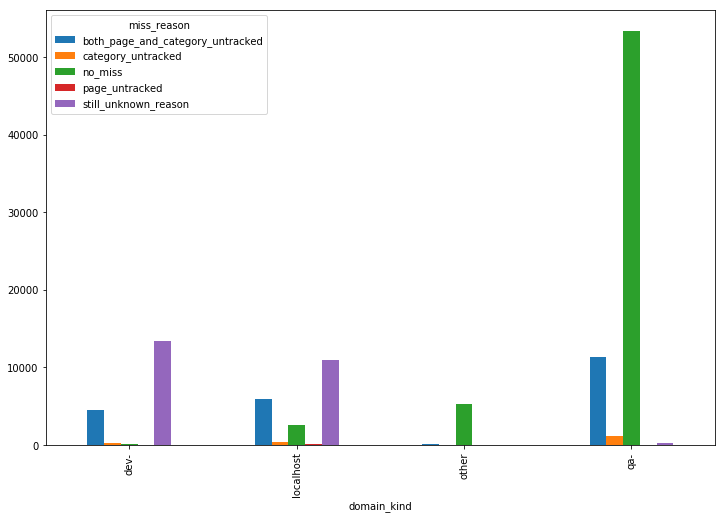

In [519]:
df.groupby(['domain_kind', 'miss_reason']).size().unstack().plot.bar()

Из графика выше можно сделать вывод, что "unknown_reason" наблюдается только для dev- и localhost, а в случае с qa его вклад не имеет статистической значимости. Т.е. какой бы причина не была, она не влияет на готовые к продакшну страницы и скорее всего обучловлена поведением js-скриптов в процессе отладочных запусков.

# Выводы и рекомендации
## Выводы
1. Есть события, которые видны в DMPkit, но не видны в GA. Это повторяющиеся события от одного пользователя, которые неким образом фильтруются на стороне Google. Эти события на самом деле есть, и в данном случае "прав" DMPkit.
2. Есть события с dev и qa сайтов, которые видны в GA, но не видны в DMPkit. Это происходит по одной из двух причин:
    1. На странице не установлен сниппет DMPkit, либо пересылка соответствующего события не настроена в GTM. (примерно 50% потерь)
    2. Страница находится в разработке (запускается локально или на dev- домене), что каким-то образом влияет на поведение js-скриптов на ней. Дальнейшее исследование не проводится, поскольку очевидно, что на qa-страницах такой проблемы нет. (примерно 50% потерь)

## Рекомендации
1. Для страниц из списка untracked_pages (см параграф "Проверка гипотезы: Не для всех событий GTM созданы условия, чтобы они дублировались в DMPkit") проверить, что на них корректно размещён сниппет TM и во вкладке network инструментов разработчика в браузере видно, что уходят события в DMPkit.
2. Для событий GTM из списка untracked_categories (см параграф "Проверка гипотезы: Не для всех событий GTM созданы условия, чтобы они дублировались в DMPkit") проверить, что в GTM корректно настроена отправка событий, и в браузере во вкладке network инструментов разработчика видно, что уходят события в DMPkit.
3. Отключить отправку дублирующихся событий при каждом повороте рулетки-баннера на главной странице портала (или хотя бы ограничиться одним просмотром каждого баннера)
4. Выполнить проверки из этого отчёта ещё раз после выкатывания страниц с такой пересылкой событий в прод.

# Дополнительно: проверка отставания событий по времени

In [521]:
# filters
## take only joined events
df = joined_df[joined_df['intersection'] == 'both']
## take particular timerange (where data collection had aleady been collecting right)
df = df[(df['datetime'] >= datetime(2019, 10, 7)) & 
        (df['datetime'] < datetime(2019, 10, 9, 23))]

Вычисляем разницу по времени между обработкой события в DMPkit и dimension11 из GTM и смотрим общие показатели в секундах:

In [522]:
df['dmpkit_ts_diff'] = df['dmpkit_ts'] - df['ts_from_js_ga']

df.describe()['dmpkit_ts_diff'] / 1000

count     61.389000
mean       0.383790
std       10.256003
min     -179.711000
25%        0.023000
50%        0.049000
75%        0.073000
max      404.539000
Name: dmpkit_ts_diff, dtype: float64

Строим статичтику по порогам задержки, указанным Катей, в процентах:

In [523]:
def buckets(val):
    aval = abs(val / 1000)
    thresholds = [30, 60, 300, 3600, 21600]
    for t in thresholds:
        if aval < t:
            return "<{}".format(t)
    return ">{}".format(thresholds[-1])

df['ts_stat'] = df['dmpkit_ts_diff'].apply(buckets)

group = df.groupby(['ts_stat']).size()
group / group.sum()

ts_stat
<30      0.994250
<300     0.001955
<3600    0.000375
<60      0.003421
dtype: float64

Рисуем график во времени:

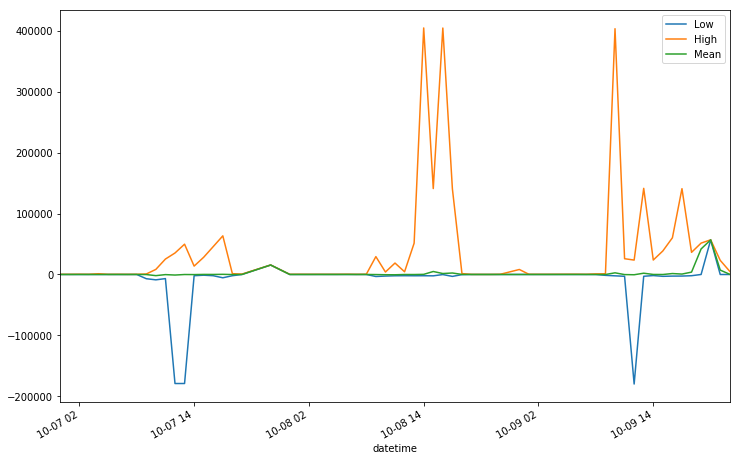

In [524]:
df.groupby('datetime')['dmpkit_ts_diff'].agg({'Low':'min', 'High':'max', 'Mean':'mean'}).plot()